In this notebook we'll implement GoogLeNet with Inception blocks from scratch
using Pytorch

We'll use a tiny version of ImageNet to experiment with

The code is followed by some explanation

Original article: https://arxiv.org/pdf/1409.4842.pdf

In [8]:
import time
import copy
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from UnityDataset import CustomData

torch.manual_seed(17)

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [10]:
# Set the dataset_path to a path containing a SOLO dataset generated by the
# Unity environment.
dataset_path = "S:\datasets\solo250kv2"
dataset = CustomData(dataset_path, transform=transform)

finished setting up dataset
Items in dataset: 100


In [11]:
train_data, val_data = torch.utils.data.random_split(dataset, [225000, 25000])

In [12]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=8)

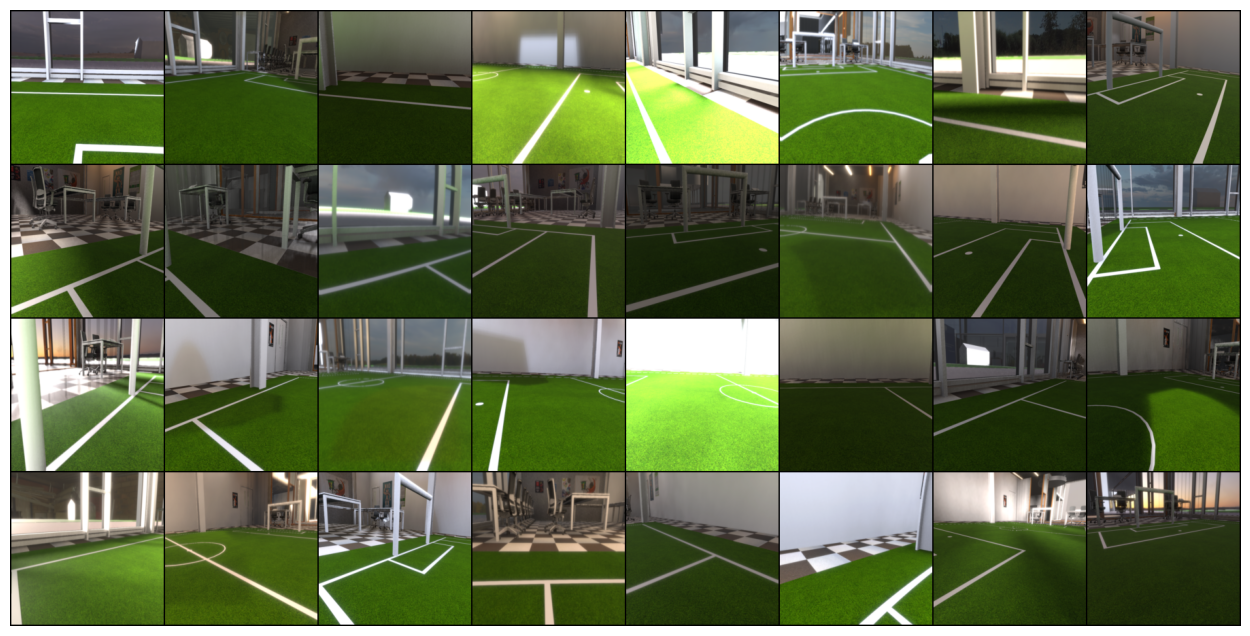

In [13]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images[:32], nrow=8).permute((1, 2, 0)))
    break

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [15]:
class InceptionBlock(nn.Module):
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [16]:
class Auxiliary(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.8)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the model

In [17]:
class Inception(nn.Module):
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=(61 * 91)):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.55)
        self.linear = nn.Linear(1024, num_classes)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)

        return x, y, z

In [18]:
model = Inception()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda

True

In [21]:
#define everything we need for training
epochs = 50 #50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# Training
Take a look at the training function. If use_auxiliary=True, during training we take into account predictions made by auxiliary classifiers - we add their weighted losses to the loss of the main classifier

In [22]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    with open(f'{dataset.captures}loss.txt', 'w') as f:

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            for phase in ['train', 'val']: # Each epoch has a training and validation phase
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]: # Iterate over data
                    inputs = inputs.to(device)

                    labels = labels.to(device)

                    optimizer.zero_grad() # Zero the parameter gradients

                    with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                        if phase == 'train': # Backward + optimize only if in training phase
                            if use_auxiliary:
                                outputs, aux1, aux2 = model(inputs)
                                loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                            else:
                                outputs, _, _ = model(inputs)
                                loss = criterion(outputs, labels)

                            _, preds = torch.max(outputs, 1)
                            loss.backward()
                            optimizer.step()

                        if phase == 'val':
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'val': # Adjust learning rate based on val loss
                    lr_scheduler.step(epoch_loss)

                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                f.write(f"{epoch_loss}, {epoch_acc}\n")

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(epoch_acc)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        f.close()
        return model, val_acc_history

In [23]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)
if os.name == 'nt':
    filename = "DATASET" + dataset_path.split("\\")[-1] + "EPOCHS" + str(epochs) + ".pt"
else:
    filename = "DATASET" + dataset_path.split("/")[-1] + "EPOCHS" + str(epochs) + ".pt"

# Save the trained model to a file.
torch.save(model.state_dict(), filename)

Epoch 0/49
----------
train Loss: 13.9616 Acc: 0.0000
val Loss: 8.6094 Acc: 0.0000

Epoch 1/49
----------
train Loss: 13.5599 Acc: 0.0000
val Loss: 8.6039 Acc: 0.0000

Epoch 2/49
----------
train Loss: 13.2409 Acc: 0.0111
val Loss: 8.5984 Acc: 0.0000

Epoch 3/49
----------
train Loss: 13.0430 Acc: 0.0222
val Loss: 8.5924 Acc: 0.0000

Epoch 4/49
----------
train Loss: 12.6501 Acc: 0.1444
val Loss: 8.5859 Acc: 0.0000

Epoch 5/49
----------
train Loss: 12.3694 Acc: 0.3333
val Loss: 8.5789 Acc: 0.0000

Epoch 6/49
----------
train Loss: 12.0790 Acc: 0.5333
val Loss: 8.5717 Acc: 0.0000

Epoch 7/49
----------
train Loss: 11.8399 Acc: 0.7222
val Loss: 8.5647 Acc: 0.0000

Epoch 8/49
----------
train Loss: 11.4844 Acc: 0.7556
val Loss: 8.5571 Acc: 0.0000

Epoch 9/49
----------
train Loss: 11.2923 Acc: 0.8778
val Loss: 8.5494 Acc: 0.0000

Epoch 10/49
----------
train Loss: 11.0208 Acc: 0.9222
val Loss: 8.5414 Acc: 0.0000

Epoch 11/49
----------
train Loss: 10.7257 Acc: 0.9667
val Loss: 8.5328 Acc